Exercise 01
===========

In [1]:
import numpy
from matplotlib import pyplot
from matplotlib import colors
% matplotlib inline

In [2]:
import os, sys
sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0])

In [3]:
import utils.quadrature as quad
import utils.elems.one_d as elem1d

## (a)

$$
\int_{-1}^{1} \int_{-1}^{1} \xi_{1}^{4} \xi_{2}^{5} d\xi_1 d\xi_2 = 
\left[\frac{1}{5}\xi_{1}^5\right]_{-1}^{1}
\times
\left[\frac{1}{6}\xi_{2}^6\right]_{-1}^{1} =
0
$$

In [4]:
def f1(x):
    """f1 = x^4"""
    return numpy.power(x, 4)

def f2(x):
    """fx = x^5"""
    return numpy.power(x, 5)

In [5]:
Q = 7

qd1 = quad.GaussLobattoJacobi(Q)
qd2 = qd1  # warning: qd2 actually points to qd1

print("The exact solution is: {0}".format(0.))
print("The numerical results is: {0}".format(qd1(f1) * qd2(f2)))

The exact solution is: 0.0
The numerical results is: 0.0


## (b)

For quadrilateral tensorial expansion
$\phi_{pq}(\xi_1, \xi_2)=\phi_p^a(\xi_1)\phi_q^a(\xi_2)$, construct the mass matrix with the same order $P$ in both $\xi_1$ and $\xi_2$ directions
$$
M[i][j] = M[pq2i(p, q)][pg2i(r, s)] = 
\int_{-1}^{1} \int_{-1}^{1}\phi_{pq}(\xi_1, \xi_2)\phi_{rs}(\xi_1, \xi_2) d\xi_1 d\xi_2
$$
where the mapping function $pq2i(p, q) = i$ maps the tensorial representation $(p,\ q)$ to the single-value index $i$.

The above integral can be furthermore decomposed into
$$
\int_{-1}^{1} \int_{-1}^{1}\phi_{pq}(\xi_1, \xi_2)\phi_{rs}(\xi_1, \xi_2) d\xi_1 d\xi_2 = \\
\int_{-1}^{1} \int_{-1}^{1}\phi_p^a(\xi_1)\phi_q^a(\xi_2)\phi_r^a(\xi_1)\phi_s^a(\xi_2) d\xi_1 d\xi_2 =
\int_{-1}^{1} \phi_p^a(\xi_1) \phi_r^a(\xi_1) d\xi_1 \times
\int_{-1}^{1} \phi_q^a(\xi_2) \phi_s^a(\xi_2) d\xi_2
$$

Before we develop a 2D standard quadrilateral element in the **utils** package,
we can here use standard 1D element in the **utils** package to handle the above calculation.
That is to say,
$$
M[i][j] = M[pq2i(p, q)][pg2i(r, s)] = \\
\int_{-1}^{1} \phi_p^a(\xi_1) \phi_r^a(\xi_1) d\xi_1 \times
\int_{-1}^{1} \phi_q^a(\xi_2) \phi_s^a(\xi_2) d\xi_2 =
M_{1D}[p][r] \times M_{1D}[q][s]
$$

We first investigate the sequential numbering of the mapping: $pq2i(p, q) = p \times (P+1) + q$.

In [6]:
def create_i2pq(P):
    """create sequential mapping of i2pg[i]=[p, q]"""
    N = (P + 1)
    N *= N
    ans = numpy.zeros((N, 2), dtype=numpy.int)
    for i in range(N):
        ans[i] = [int(i/(P+1)), i%(P+1)]
    return ans

In [7]:
def ex_b(P):
    """the wrapper for exercise (b)"""
    N = (P + 1) * (P + 1)
    i2pq = create_i2pq(P)
    e = elem1d.CommonJacobiElem([-1, 1], P+1)
    M = numpy.matrix(numpy.zeros((N, N), dtype=numpy.float64))
    Mp = numpy.zeros_like(M, dtype=numpy.int)  # for plotting matrix structure
    for i in range(N):
        for j in range(N):
            p, q = i2pq[i]
            r, s = i2pq[j]
            M[i, j] = e.M[p, r] * e.M[q, s]
            if M[i, j] != 0:
                Mp[i, j] = 1
    return Mp

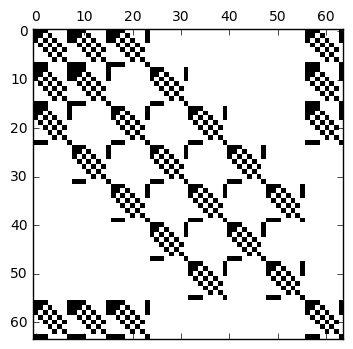

In [8]:
P = 7
Mp = ex_b(P)
pyplot.matshow(Mp, cmap=colors.ListedColormap(['white', 'black']));

If we use decomposed numbering scheme, i.e., number the boundary modes first, the matrix will look like:

In [9]:
def create_i2pq(P):
    """create sequential mapping of i2pg[i]=[p, q]"""
    N = (P + 1)
    N *= N
    ans = numpy.zeros((N, 2), dtype=numpy.int)
    ans[0:4] = [[0, 0], [0, P], [P, 0], [P, P]]
    ans[4:4+P-1] = [[i, 0] for i in range(1, P)]
    ans[4+P-1:4+2*P-2] = [[i, P] for i in range(1, P)]
    ans[4+2*P-2:4+3*P-3] = [[0, i] for i in range(1, P)]
    ans[4+3*P-3:4+4*P-4] = [[P, i] for i in range(1, P)]
    ans[4+4*P-4:] = [[i, j] for i in range(1, P) for j in range(1, P)]
    return ans

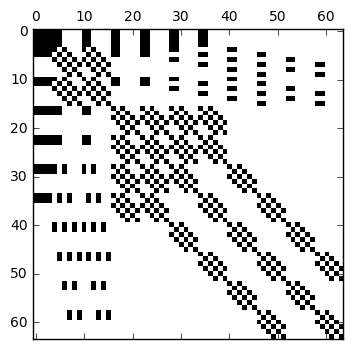

In [10]:
Mp = ex_b(P)
pyplot.matshow(Mp, cmap=colors.ListedColormap(['white', 'black']));

To mimic the structure mass matrix of standard triangle (Fig. 3.18), we can delete the rows and columns involving the edges of $(\overline{0,P)(P,P)}$. Then the matrix structure should be similar to the Fig. 3.18.

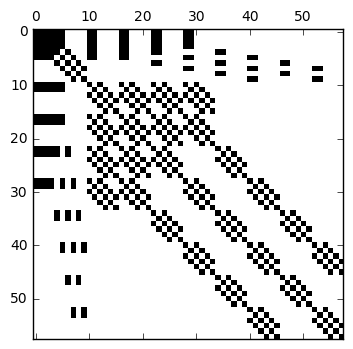

In [11]:
Mp = numpy.delete(Mp, numpy.s_[4+P-1:4+2*P-2], 0)
Mp = numpy.delete(Mp, numpy.s_[4+P-1:4+2*P-2], 1)
pyplot.matshow(Mp, cmap=colors.ListedColormap(['white', 'black']));

## (c)

The same as the exercise (c) except that now use pure Legendre polynomial expansion, instead of p-type expansion. That is to say, $\phi_p^a(\xi)=\tilde{\psi_p^a}(\xi)=L_{p}^{0,0}(\xi)$

In [12]:
def ex_c(P):
    """the wrapper for exercise (b)"""
    N = (P + 1) * (P + 1)
    i2pq = create_i2pq(P)
    e = elem1d.PureLegendreElem([-1, 1], P+1)
    M = numpy.matrix(numpy.zeros((N, N), dtype=numpy.float64))
    Mp = numpy.zeros_like(M, dtype=numpy.int)  # for plotting matrix structure
    for i in range(N):
        for j in range(N):
            p, q = i2pq[i]
            r, s = i2pq[j]
            M[i, j] = e.M[p, r] * e.M[q, s]
            if M[i, j] != 0:
                Mp[i, j] = 1
    return Mp

First, the sequential numbering:

In [13]:
def create_i2pq(P):
    """create sequential mapping of i2pg[i]=[p, q]"""
    N = (P + 1)
    N *= N
    ans = numpy.zeros((N, 2), dtype=numpy.int)
    for i in range(N):
        ans[i] = [int(i/(P+1)), i%(P+1)]
    return ans

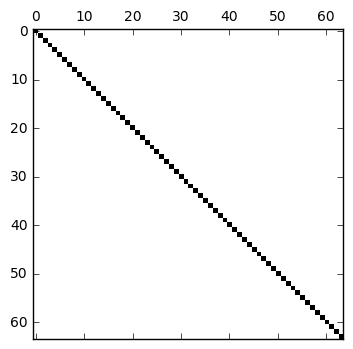

In [14]:
P = 7
Mp = ex_c(P)
pyplot.matshow(Mp, cmap=colors.ListedColormap(['white', 'black']));

Next, the decomposed numbering:

In [15]:
def create_i2pq(P):
    """create sequential mapping of i2pg[i]=[p, q]"""
    N = (P + 1)
    N *= N
    ans = numpy.zeros((N, 2), dtype=numpy.int)
    ans[0:4] = [[0, 0], [0, P], [P, 0], [P, P]]
    ans[4:4+P-1] = [[i, 0] for i in range(1, P)]
    ans[4+P-1:4+2*P-2] = [[i, P] for i in range(1, P)]
    ans[4+2*P-2:4+3*P-3] = [[0, i] for i in range(1, P)]
    ans[4+3*P-3:4+4*P-4] = [[P, i] for i in range(1, P)]
    ans[4+4*P-4:] = [[i, j] for i in range(1, P) for j in range(1, P)]
    return ans

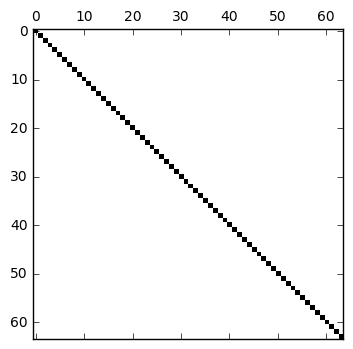

In [16]:
P = 7
Mp = ex_c(P)
pyplot.matshow(Mp, cmap=colors.ListedColormap(['white', 'black']));

## (d)

Nodal expansions are not in my interest, so I currently skip this part.